# Google Rank and Pareto Alloctions 

## By Jonah Heyl


This borrows code from the type allocation notebook, made by Prof. Peters, and James Yu; however, it takes a considerably different approach when it comes to allocating universities into tiers. Here we use the inverse google page rank algorithm to rank all of the universities. Then we group universities into tiers, based on the distribution of page ranks. The reason we use page ranks is, that using the raw number of outcomes to group lacks, relativity. For instance, let's say MIT has 20 grads (over the range where investigating), and the University of Fudan has 200 grads. Now suppose all MIT grads go to work at Harvard as assistant professors, and 30 of Fudan's grads go to Harvard. You would think MIT is a better school right, well in the monte Carlo simulation is previously done, the University of FUDAN would be more likely to get into the first tier (given MIT and Fudan are the same in every other regard). This brings us to our next problem, the original tiers were made using a stochastic algorithm. Charting out the space of possible solutions, to find a "good" ranking is nearly computational impossible. Thus there is absolutely no assurance that the ordinal ranks presented are indeed the global minimum. This new approach does have some weaknesses, as well for instance it assumes the page rankings follow a piecewise Pareto distribution, furthermore it's using an inverse google page rank as a metric for academic quality. Both of these assumptions we will discuss later. Also note that the original method did not initially rank the clusters, until after the allocation was done; however, the points made are true when thinking about the entire process.

###  Set up:

In [1]:
YEAR_INTERVAL = range(2002,2022)  # change this to select the years of data to include in the estimation


In [2]:
import os
try:
    import requests as rq
except:
    os.system("pip install requests")
    import requests as rq
try:
    import json
except:
    os.system("pip install json")
    import json
try:
    import numpy as np
except:
    os.system("pip install numpy")
    import numpy as np


In [3]:
np.random.seed(1234)

In [4]:
def get_data(url):
    resp =rq.get(url);
    es = resp.json()
    return es


In [5]:
def find_inst(name,outcomes,to_from = False):
    check = False
    for outcome in outcomes:
        if to_from == True:
            if outcome["to_name"] == name:
                print('\n'+outcome)
                check = True
            
        else:
            if outcome["from_institution_name"] == name:
                print('\n',outcome)
                check = True
            
        
    
    if check == False:
        print('\n'+"Not found")
    

This part gets all the placement data using `https://support.econjobmarket.org/api/placement_data`

In [6]:
url = "https://support.econjobmarket.org/api/placement_data"
placements = get_data(url)
print(len(placements),sep='\n')
#print(type(placements),sep='\n')

14678


In [7]:
u= lambda x:  [i for n, i in enumerate(x) if i not in x[:n]]
print(len(placements),'\n')
placements = u(placements)
print(len(placements),sep='\n')

14678 

14678


In [8]:
i = 0
oid_mapping = {}
institution_mapping = {}
academic = []
academic_to = []
academic_builder = []
sink_builder = []
for placement in placements:
    if int(placement["year"]) in YEAR_INTERVAL:
            academic.append(placement["from_institution_name"])
            academic_to.append( placement["to_name"])
            oid_mapping[placement["from_oid"]] = placement["from_institution_id"]
            oid_mapping[placement["to_oid"]] = placement["to_institution_id"]
            institution_mapping[placement["from_institution_id"]] = placement["from_institution_name"]
            institution_mapping[placement["to_institution_id"]] = placement["to_name"]
            if placement["position_name"] == "Assistant Professor":
               academic_builder.append( placement)
            else:
                sink_builder.append(placement)


academic_builder=academic_builder;sink_builder=u(sink_builder);academic=u(academic);academic_to=u(academic_to);sink_builder=u(sink_builder)
print(len(academic_builder), " total assistant professor outcomes",'\n')
print(len(sink_builder), " other outcomes",'\n')
print(len(academic_builder)+len(sink_builder),'\n') 

7036  total assistant professor outcomes 

7239  other outcomes 

14275 



In [9]:
all_inst= academic_builder+sink_builder
print(len(all_inst),'\n')

14275 



We set the year itnerval to the the whole interval of placements; however if you set it to something else, than this number would be smaller. 

In [10]:
tch_sink = [] # sink of teaching universities that do not graduate PhDs
for key in academic_to:
    if not(key in academic):
        tch_sink.append(key)
tch_sink=u(tch_sink)
print("academic:",len(academic),'\n')
print("academic_to:",len(academic_to),'\n')
print("tch_sink:",len(tch_sink),'\n')

academic: 711 

academic_to: 1792 

tch_sink: 1185 



The next piece of code sorts all the sink departments (except teaching universities, which are dealt with above) by category:

In [11]:


acd_sink = []
gov_sink = []
pri_sink = []
count=0
for outcome in sink_builder:
    # CODE global academic, other_placements, pri_sink, gov_sink, acd_sink
    if outcome["recruiter_type"] in ["6","7"]:
        # private sector: for and not for profit
        pri_sink+=[(outcome["to_name"], " (private sector)")]
    elif outcome["recruiter_type"] == "5":
        # government institution
        gov_sink+=[(outcome["to_name"], " (public sector)")]
    else:
        # everything else including terminal academic positions
        acd_sink+=[(outcome["to_name"], " (academic sink)")]
        count+=1
    

acd_sink=u(acd_sink);gov_sink=u(gov_sink);pri_sink=u(pri_sink)
print(len(acd_sink),'\n')
print(len(gov_sink),'\n')
print(len(pri_sink),'\n')

882 

147 

191 



Instead of constructing the adjency matrix, we will construct a wiehgted dirrected graph with all of the univirsities.

In [12]:
institutions = academic+ acd_sink+gov_sink+pri_sink+tch_sink

In [13]:
len(institutions)

3116

In [15]:
out = np.zeros((len(institutions), len(academic)) )
i = 0
for outcome in academic_builder:
    i += 1
    try:
        out[np.where(outcome["to_name"]==institutions)[0][0],np.where(outcome["from_institution_name"]==institutions)[0][0]]+=1
    except IndexError:
        pass

for outcome in sink_builder:
    i += 1
    keycheck = ""
    if outcome["recruiter_type"] in ["6", "7"]:
        keycheck = str(outcome["to_name"]) # + " (private sector)"
    elif outcome["recruiter_type"] == "5":
        keycheck = outcome["to_name"] # + " (public sector)"
    else:
        keycheck = outcome["to_name"] # + "(academic sink)"
    
    #println(keycheck)
    #println(findfirst(isequal(keycheck), institutions))
    #println(outcome["from_institution_name"]," ",findfirst(isequal(outcome["from_institution_name"]), institutions))
    try:
        out[np.where(keycheck== institutions)[0][0],np.where(outcome["from_institution_name"]== institutions)[0][0]] += 1
    except IndexError:
        pass

print("Total number of outcomes: ", i,'\n',sep=' ')
print(len(gov_sink),'\n')
print(len(pri_sink),'\n')



Total number of outcomes:  14275 

147 

191 



### Createing the dirrected graph:

Here we start makeing a dirrected graph, each node is a unvirsitity which has many edges, each of which are dirrected.  The edges connect the unvirsities from a given set of placements.But the dirrection is flipped, so if the dirrected edge points into Harvard, it means the from_insutions in the given placement is Harvard.The converse is true for the edges that point away from the unvirisities. Now each edge is wieghted, by the number of placements of that type that occur in the data. So, if Harvard had 3 people end up working at stripe, then there would be two edges, one pointing into hHrved from stripe, and another pointing away from stripe ,both would be wieghted three.This is what is meant by an "inverse google search rank", we are flipping the dirrection of the arrows. This because good unviristities are typical thought of as ones that get their grads jobs at highly slective places, not unviristies that hire lots of people.

In [16]:
try:
    import networkx as nx
except:
    os.system("pip install networkx")
    import networkx as nx

In [17]:
DG = nx.DiGraph()
DG.add_nodes_from(institutions)

This next cell makes a dirrected wieghted graph of all the placements

In [18]:
for inst in institutions:
        l=list(filter(lambda e: e["from_institution_name"]==inst,placements)) 
        to_names=list(map(lambda i: i["to_name"],l))
        for name in u(to_names):
                DG.add_weighted_edges_from([(name, inst, to_names.count(name))])  #putting the edges bacwards
                
  
        
  
           

# Google Page Rank Algorithim

Here we use the google page rank algorithim to rank all of the unvirsities. Now what is the google page rank, algorithim, well it ranks insutations based on the probabibility of being at a given insution for a being who is pepertally getting hired and graduteing from unviristies.This is also approximatly, many people graduteing and getting hired at different places over a finite peirod of time.This describes the eigon-vector  of the adjency matrix of our graph (in patricalr the egion vector with the highest egion value).

In [19]:
from networkx import pagerank 

In [20]:
def pagerank_numpy(G, alpha=0.85, personalization=None, weight='weight', dangling=None): 

    if len(G) == 0:
        return {}

    M = nx.google_matrix(G, alpha, personalization=personalization,
                      weight=weight, dangling=dangling)

    eigenvalues, eigenvectors = np.linalg.eig(M.T)
    ind = eigenvalues.argsort()
    largest = np.array(eigenvectors[:, ind[-1]]).flatten().real
    norm = float(largest.sum())

    return dict(zip(G, map(float, largest / norm))) 

In [21]:
pr=pagerank_numpy(DG)

C:\Users\Jonah\AppData\Local\Temp\ipykernel_22428\2301286281.py:6: FutureWarning: google_matrix will return an np.ndarray instead of a np.matrix in
NetworkX version 3.0.
  M = nx.google_matrix(G, alpha, personalization=personalization,


In [25]:
DG.edges('University of California Los Angeles (UCLA)', 'University of California Los Angeles (UCLA)')

OutEdgeDataView([('University of California Los Angeles (UCLA)', 'University of California Los Angeles (UCLA)', None), ('University of California Los Angeles (UCLA)', 'University of Maryland', None), ('University of California Los Angeles (UCLA)', 'New York University', None), ('University of California Los Angeles (UCLA)', 'Yale University', None), ('University of California Los Angeles (UCLA)', 'Harvard University', None), ('University of California Los Angeles (UCLA)', 'Princeton University', None), ('University of California Los Angeles (UCLA)', 'University of Michigan', None), ('University of California Los Angeles (UCLA)', 'Duke University', None), ('University of California Los Angeles (UCLA)', 'Stanford University', None), ('University of California Los Angeles (UCLA)', 'Massachusetts Institute of Technology', None), ('University of California Los Angeles (UCLA)', 'University of California, Berkeley', None), ('University of California Los Angeles (UCLA)', 'Northwestern Universi

In [22]:
marklist = sorted(pr.items(), key=lambda x:-x[1])
s = dict(marklist)
newdict={}
for key in s:
    if type(key) is str:
        newdict[key]=s[key]
    else:
        newdict[key[0]]=s[key]

        


In [23]:
for ii,key in enumerate(s):
    if ii>100:
        break
    print(ii+1,key,s[key])

1 Harvard University 0.04229019327101524
2 University of California, Berkeley 0.028497823652320006
3 Stanford University 0.02376190552364624
4 Princeton University 0.022077565950223497
5 Yale University 0.02172885780463156
6 University of Michigan 0.019980969419745177
7 University of Chicago 0.019161213994096815
8 London School of Economics and Political Science 0.015795583815055622
9 Massachusetts Institute of Technology 0.015684890997472653
10 Columbia University 0.01527336166631159
11 Northwestern University 0.014108143632889404
12 University of Maryland 0.013398809554691398
13 University of California Los Angeles (UCLA) 0.012961743839391552
14 New York University 0.012126571121195294
15 University of Pennsylvania 0.011524268321641747
16 Duke University 0.010670111703927013
17 University of Wisconsin, Madison 0.010451201709940646
18 University of Oxford 0.010437205875408148
19 Boston University 0.00862868547130466
20 University of Nottingham 0.00829045256374644
21 Toulouse School of

In [93]:
for ii,key in enumerate(newdict):
    if ii>5:
        break
    print(key,newdict[key])

Harvard University 8.400758080098165e-05
University of California, Berkeley 8.400758080098165e-05
Stanford University 8.400758080098165e-05
Princeton University 8.400758080098165e-05
Yale University 8.400758080098165e-05
University of Michigan 8.400758080098165e-05


In [94]:
#li=list(s) #this saves the ranking
jj= json.dumps(newdict)
with open("google_rank4","w") as f:
    f.write(jj)


### Tiers:

What we notice is that there four distictint groups each corrsponding to a different pareto distrubtion. The ranks within each group, may be influenced by the number of outcomes. We do see a strong correlation between the number of grads and the page rank; however, it is evident that there are other factors at play.

In [95]:
try:
    import matplotlib.pyplot as plt
except:
    os.system("pip install matplotlib.pyplot")
    import matplotlib.pyplot as plt

In [96]:
number_grads={}
for uni in list(DG.nodes()):
    count=0
    for ed in list(DG.edges(uni)):
        count+=DG.edges[ed]['weight'] 
    number_grads[uni]=count
   

In [97]:
number_grads['New York University']

93

In [98]:
for_graph1 = list(map( lambda i: number_grads.get(i),institutions ))
for_graph2=list(map( lambda i: s.get(i),institutions ))




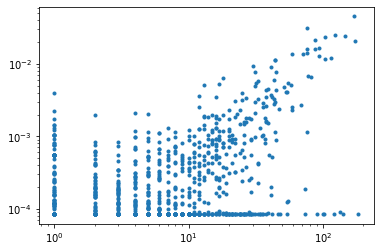

In [99]:
plt.loglog(for_graph1,for_graph2,".")  

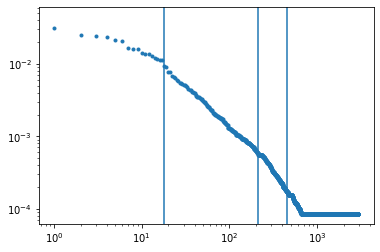

In [100]:
ii=[i for i in s.values()]
plt.loglog(ii,'.')
plt.axvline(18)
plt.axvline(210)
plt.axvline(450)
#plt.loglog([10,1000],[3e-3,3e-4])

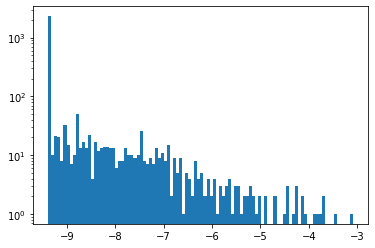

In [101]:
aa=plt.hist(np.log(ii),bins=100)
plt.yscale('log')

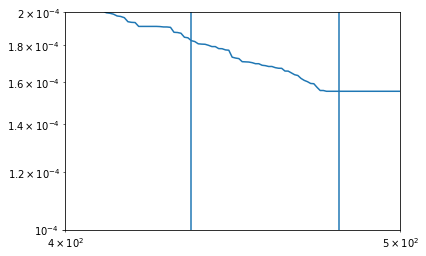

In [102]:
ii=[i for i in s.values()]
plt.loglog(ii)
plt.xlim(400,500)
plt.ylim(1e-4,2e-4)
plt.axvline(17)
plt.axvline(210)
plt.axvline(435)
plt.axvline(480)
#plt.loglog([10,1000],[3e-3,3e-4])

# This sorts out sinks, and then orders the univristies.

In [103]:
gov_sink_ranks = {name:s.get(name) for name in gov_sink}
pri_sink_ranks = {name:s.get(name) for name in pri_sink}
tch_sink_ranks = {name:s.get(name) for name in tch_sink}
acd_sink_ranks= {name:s.get(name) for name in acd_sink}
academic_ranks = {name:s.get(name) for name in academic}


In [104]:
def ranker(d):
    sorted_dict = {}
    sorted_keys = sorted(d, key=d.get,reverse=True)
    for w in sorted_keys:
        sorted_dict[w] = d[w]
    return sorted_dict

In [105]:
sorted_tuples = sorted(academic_ranks.items(), key=lambda item: item[1])
sorted_ranks = {k: v for k, v in sorted_tuples}

In [106]:
ordered_acadmic_ranks=ranker(academic_ranks)
ordered_gov_sink_ranks=ranker(gov_sink_ranks) 
ordered_pri_sink_ranks=ranker(pri_sink_ranks)
ordered_tch_sink_ranks=ranker(tch_sink_ranks)
ordered_acd_sink_ranks=ranker(acd_sink_ranks)

In [107]:
ii=[i for i in ordered_acadmic_ranks.values()]

# Tiers of Acadmic Insututions

Here rather than grouping placements based off haveing a simalar number of outcomes we group placements for being in the same pareto distrubtion. We can see from the graph above, that the distrubtion of pages ranks is one of a piecewise paperto distrubtion. By this it is meant that,

$f(x) = \left\{ \begin{matrix} f_1(x) & x \leq x_2 \\ f_2(x) & x_2\geq x \leq x_3 \\ f_3(x) & x_3 \geq x \\ \end{matrix}\right.$



Where,


$f_i(x) = \frac{\alpha x_m^\alpha}{x^{\alpha+1}}$. We will use a maximum likelhood framework to determine the cutoffs as well as the parameter's of each parato distrubtion. 

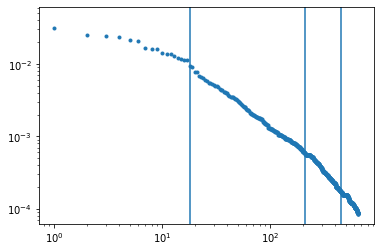

In [108]:
ii=[i for i in ordered_acadmic_ranks.values()]
plt.loglog(ii,'.')
plt.axvline(18)
plt.axvline(210)
plt.axvline(450)

In [109]:
from scipy.integrate import quad
ii=np.array(ii)
igood=ii[ii>ii[450]*1.1]
imin=igood.min()
imax=igood.max()
def pareto_funk(val,x):
    return np.where(val<x[1],val**x[0],np.where(val<x[3],(val/x[1])**x[2],np.where(val<x[5],(val/x[3])**x[4],(val/x[5])**x[6]*(x[5]/x[3])**x[4])*(x[3]/x[1])**x[2])*x[1]**x[0])
def pareto_loglike(x):
    fval=pareto_funk(igood,x)
    Npred=quad(lambda val: pareto_funk(val,x),imin,imax)
    return -(np.sum(np.log(fval/Npred[0]))-len(igood))

In [110]:
from scipy.integrate import quad

In [111]:
ii=np.array(ii) 
#igood=ii[ii>ii[450]*1.1]
#imin=igood.min()
#imax=igood.max()
def pareto_funk(val,x):
    return np.where(val<x[1],val**x[0],np.where(val<x[3],(val/x[1])**x[2],np.where(val<x[5],(val/x[3])**x[4],(val/x[5])**x[6]*(x[5]/x[3])**x[4])*(x[3]/x[1])**x[2])*x[1]**x[0])
def pareto_loglike(x):
    fval=pareto_funk(igood,x)
    Npred=quad(lambda val: pareto_funk(val,x),imin,imax)
    return -(np.sum(np.log(fval/Npred[0]))-len(igood))

In [112]:
imin,imax

(0.0001905501866826185, 0.04531189597188701)

In [113]:
#quad(lambda val: pareto_funk(val,[0.1,1e-3,0.2,1e-2,0.3]),1e-4,1e-1)


In [114]:
from scipy.optimize import minimize
#res=minimize(pareto_loglike,[-1.2,5e-4,-1.8,3e-3,-1.5,2e-2,-3])

In [115]:
#res

In [116]:
res2=minimize(pareto_loglike,res.x*(1+np.random.normal(size=7)*0.2),method='Nelder-Mead') # we use this method because the above one fails
res2

C:\Users\Jonah\AppData\Local\Temp\ipykernel_8480\3428278021.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Npred=quad(lambda val: pareto_funk(val,x),imin,imax)


 final_simplex: (array([[-1.25812947e+00,  8.38832686e-04, -1.96572117e+00,
         8.63071415e-03, -1.12889030e+00,  2.33562521e-02,
        -3.76664911e+00],
       [-1.25813122e+00,  8.38832654e-04, -1.96572356e+00,
         8.63073016e-03, -1.12888842e+00,  2.33562520e-02,
        -3.76663290e+00],
       [-1.25813310e+00,  8.38832701e-04, -1.96571656e+00,
         8.63073410e-03, -1.12889262e+00,  2.33562518e-02,
        -3.76660676e+00],
       [-1.25812577e+00,  8.38832649e-04, -1.96572855e+00,
         8.63070087e-03, -1.12888597e+00,  2.33562522e-02,
        -3.76669232e+00],
       [-1.25813360e+00,  8.38832663e-04, -1.96572218e+00,
         8.63075652e-03, -1.12888814e+00,  2.33562525e-02,
        -3.76659887e+00],
       [-1.25811791e+00,  8.38832692e-04, -1.96573198e+00,
         8.63074570e-03, -1.12887870e+00,  2.33562522e-02,
        -3.76670882e+00],
       [-1.25813749e+00,  8.38832737e-04, -1.96572119e+00,
         8.63076300e-03, -1.12888964e+00,  2.33562520e-02,
 

The reason the Nelder mead doesn't fail is that it does not take numerical derivatives, unlike the previous minimizer. Due to the jumps in distribution, taking numerical derivatives is not an appropriate way to solve this problem.

In [117]:
cuttoffs=[res2["x"][1],res2["x"][3],res2["x"][5]]

array([0.00083883, 0.00863071, 0.02335625])

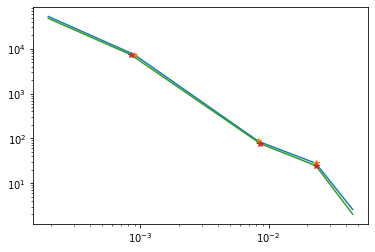

In [118]:
xxx=np.linspace(imin,imax,1001)
plt.loglog(xxx,pareto_funk(xxx,res.x))
_xx=res.x[1::2]
plt.loglog(_xx,pareto_funk(_xx,res.x),'*')
plt.loglog(xxx,pareto_funk(xxx,res2.x))
_xx=res2.x[1::2]
plt.loglog(_xx,pareto_funk(_xx,res2.x),'*')
_xx
#plt.loglog(igood,np.linspace(1,len(igood),len(igood))/len(igood))

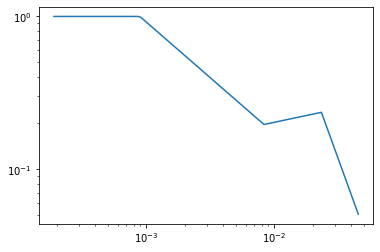

In [119]:
xxx=np.linspace(imin,imax,1001)
plt.loglog(xxx,pareto_funk(xxx,res.x)/xxx**res.x[0])
#plt.loglog(igood,np.linspace(1,len(igood),len(igood))/len(igood))

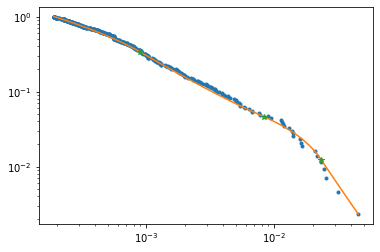

In [120]:
xxx=np.linspace(imax,imin,1001)
csum=np.cumsum(pareto_funk(xxx,res.x))
csum/=csum[-1]
csum+=1/len(igood)-csum[0]

_xx=res.x[1::2]

plt.loglog(igood,np.linspace(1,len(igood),len(igood))/len(igood),'.')
plt.loglog(xxx,csum)
plt.loglog(_xx,np.interp(_xx,xxx[::-1],csum[::-1]),'*')

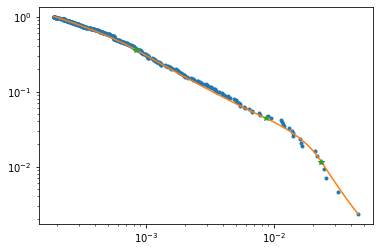

In [121]:
xxx=np.linspace(imax,imin,1001)
csum=np.cumsum(pareto_funk(xxx,res2.x))
csum/=csum[-1]
csum+=1/len(igood)-csum[0]

_xx=res2.x[1::2]

plt.loglog(igood,np.linspace(1,len(igood),len(igood))/len(igood),'.')
plt.loglog(xxx,csum)
plt.loglog(_xx,np.interp(_xx,xxx[::-1],csum[::-1]),'*')

# Finally rank the Acamadmic unviristies into to tiers

In [122]:
t1=list(filter(lambda key: ordered_acadmic_ranks[key] > cuttoffs[2] , ordered_acadmic_ranks))
t2=list(filter(lambda key: cuttoffs[1] < ordered_acadmic_ranks[key] < cuttoffs[2] , ordered_acadmic_ranks))
t3=list(filter(lambda key: cuttoffs[0] < ordered_acadmic_ranks[key] < cuttoffs[1] , ordered_acadmic_ranks))
t4=list(filter(lambda key: ordered_acadmic_ranks[key] < cuttoffs[0] , ordered_acadmic_ranks))

In [123]:
print(t1)

['Harvard University', 'University of California, Berkeley', 'Stanford University', 'Princeton University']


In [124]:
print(t2)

['Yale University', 'University of Michigan', 'University of Chicago', 'London School of Economics and Political Science', 'Massachusetts Institute of Technology', 'Columbia University', 'University of California Los Angeles (UCLA)', 'Northwestern University', 'University of Maryland', 'New York University', 'University of Oxford', 'University of Pennsylvania', 'Duke University', 'University of Wisconsin, Madison', 'Boston University', 'University of Nottingham']


In [125]:
m1=["t1"];m2=["t2"];m3=["t3"];m4=["t4"]
final_ranks=m1+t1+m2+t2+m3+t3+m4+t4
jj= json.dumps(final_ranks)
with open("google_tiers","w") as f:
        f.write(jj)

# Adjency Matrix:

Rather than transfering the alloction file with 640 rankings, and all kinds of things that can happen with unicode, we will transfer the adjency matrix to julia, for the value esitamtion.

In [126]:
#YEAR_INTERVAL = range(2017,2020)  # change this to select the years of data to include in the estimation
NUMBER_OF_TYPES = 4        # change this to select the number of types to classify academic departments into
NUMBER_OF_SINKS = 1        # change this to 4 to use individual sink types
NUMBER_OF_ROWS = NUMBER_OF_TYPES + NUMBER_OF_SINKS
TOTAL_DISTRIBUTIONS = NUMBER_OF_ROWS
# change this the index is the type as saved by the categorization progam, the value is the tier that type represents
# at the time of writing this has to be set manually using the dict o in the type allocation notebook
# this version 2021-12-22
#type_to_tier = {"1" :"3","2":"2","3":"1","4":"4","5":"5"}

The data in this notebook comes from [https://support.microeconomics.ca/api/placement_data](https://support.microeconomics.ca). We're going to use the type alloction from above, and we have the placements loaded as well.

Now we can create the adjacency matrix from the placement data using the type allocation in types  Each institution is associated with many organizations.  Organizations can have multiple type assignments if their placements have different postypes.  This function collects all the types that are assigned to an oid. By adjancey matrix we are reffering the adjacency matrix of the dirrected graph of unvirsities.

In [127]:
def look_up(uni):
    if uni in t1:
        return 0 #our tiers start at 0 rather than 1, so 0 is the same as 1 and etc
    if uni in t2:
        return 1
    if uni in t3:
        return 2
    if uni in t4:
        return 3
    else:
        return 4

In [128]:
placement_rates = np.zeros((NUMBER_OF_ROWS,NUMBER_OF_TYPES))
placement_rates

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [129]:
broke=[]
for p in placements:
    if int(p["year"]) in YEAR_INTERVAL:
        i1=look_up(p["to_name"])
        i2=look_up(p['from_institution_name'])
        try:
            placement_rates[i1,i2]+=1
        except:
            broke.append(p["from_institution_name"])

In [130]:
placement_rates

array([[ 171.,  198.,  123.,   13.],
       [ 342.,  564.,  302.,   65.],
       [ 343.,  939., 1625.,  290.],
       [ 228.,  846., 1444.,  866.],
       [ 386., 1486., 2273.,  961.]])

In [131]:
lists = placement_rates.tolist()
json_str = json.dumps(lists)
with open("mat.json","w") as f:
    f.write(json_str)


In [132]:
#broke # these placements did not work but are highly irregular

In [133]:
import itertools 

In [134]:
for j,i in itertools.product(range(NUMBER_OF_ROWS),range(NUMBER_OF_TYPES)):
    if i > j:
        if placement_rates[i, j] <= placement_rates[j, i]:
            print("FAULT: hiring ", i, " with graduating ", j, ": downward rate: ", placement_rates[i, j], ", upward rate: ", placement_rates[j, i],'\n')
print("Check Complete")

Check Complete


If everything worked fine, there should be no faults in this cell. If there are, change the order in the cell with the explicit order.
Next, we construct a numerical global minimizer for the chi-squared metric of differences between the above placement rates and a set of theoretically-predicted rates given by values $v_i$ and offer distributions $F_i(x)$. 